In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from imutils import paths
import numpy as np
import sys
import cv2
import os

sys.path.append("..")

from bodypose.training.metrics import avgMDE_2D, avgMDE_2D_RAW, Accuracy
from bodypose.training.metrics import RegressionLoss2D, AuxiliaryLoss
from bodypose.training.preprocessing import load_TFRecords_dataset  
from bodypose.training.preprocessing import augmentations
from bodypose.training.architecture import MoveNet
from bodypose.demo.graphics import draw_keypoints
from bodypose.training.architecture.custom_layers import get_max_mask

import config as cfg

In [2]:
INPUT_SHAPE = (224, 224, 3)
STRIDES = (32, 16, 8, 4)
NUM_KPTS = len(cfg.MPII_KEYPOINT_DICT)

GRID_SIZE = INPUT_SHAPE[0] // STRIDES[-1]

In [3]:
filePaths = list(paths.list_files("../dataset/tfrecords/mpii/validation/"))
print(f"[INFO] Found {len(filePaths)} TFRecords.")

ds = load_TFRecords_dataset(
    filePaths=filePaths, 
    batch_size = 10,
    target_size = INPUT_SHAPE[:2],
    grid_dim = GRID_SIZE,
    augmentations = [],
    roi_thresh = 0.9
    )

[INFO] Found 10 TFRecords.


2022-11-06 11:51:16.881064: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model = MoveNet(
    input_shape = INPUT_SHAPE, 
    strides = STRIDES, 
    num_joints = NUM_KPTS, 
    alpha = .5, 
    use_depthwise = True,
    debug=True
    )

img = (np.random.uniform(
    0, 255, (1,) + INPUT_SHAPE
    ).astype("uint8") / 255).astype(np.float32)

%timeit model(img)

143 ms ± 9.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
model.load_weights("../saved_models/movenet_224.models/")

2022-11-06 11:51:31.550262: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ../saved_models/movenet_224.models/: FAILED_PRECONDITION: ../saved_models/movenet_224.models; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [6]:
for img, (y1, y2) in ds.take(1):
    kpts, heatmaps, w_heatmaps = model(img)
    kpts = kpts[0].numpy()
    heatmaps  = heatmaps[0].numpy()

print(kpts)

[[0.4388111  0.48031634 0.6367184  0.5003513  0.6316786 ]
 [0.6951079  0.4804287  0.5919496  0.45716706 0.65331864]
 [0.7059952  0.5167546  0.4594278  0.51736444 0.4299075 ]
 [0.58974457 0.4100019  0.5900486  0.40276253 0.6659571 ]
 [0.6950743  0.481786   0.5924555  0.46933067 0.56879044]
 [0.54177636 0.54962325 0.7573402  0.55351543 0.78702414]
 [0.6045526  0.48103574 0.55431443 0.46192238 0.59276575]
 [0.2892799  0.49960983 0.5178692  0.5396872  0.35824025]
 [0.69762766 0.50435966 0.3035376  0.48338804 0.30539498]
 [0.72217447 0.5301017  0.3443453  0.53718776 0.31991377]
 [0.38213593 0.42775697 0.39037493 0.4396686  0.41303754]
 [0.65746015 0.44582498 0.38917136 0.4133286  0.4029774 ]
 [0.49481097 0.49896657 0.44719997 0.40201935 0.44835228]
 [0.6108601  0.45366925 0.37058812 0.52419263 0.47306252]
 [0.684494   0.49927062 0.45016816 0.46993157 0.46263543]
 [0.6816556  0.5321553  0.51825327 0.51658016 0.50301   ]]


In [7]:
def draw_sample(i):
    pred_img = ((img[i].numpy() + 1) * 127.5).astype('uint8').copy()
    true_img = ((img[i].numpy() + 1) * 127.5).astype('uint8').copy()

    preds, heatmaps, w_heatmaps = model.predict(img[i:i+1])
    preds = preds[0, :, :3]
    preds = preds[:, [1,2,0]]

    # Heatmaps
    kptsmask = get_max_mask(heatmaps.reshape(-1, GRID_SIZE, GRID_SIZE, NUM_KPTS+1))
    kptsmap = kptsmask[0, :, :, 1:].numpy().sum(axis=-1)
    kptsmap = cv2.resize(kptsmap, INPUT_SHAPE[:2])

    centremap = heatmaps[0, :, 0].reshape(GRID_SIZE, GRID_SIZE)
    centremap = cv2.resize(centremap, INPUT_SHAPE[:2])

    # Weighted heatmaps
    w_kptsmask = get_max_mask(w_heatmaps.reshape(-1, GRID_SIZE, GRID_SIZE, NUM_KPTS+1))
    w_kptsmap = w_kptsmask[0, :, :, 1:].numpy().sum(axis=-1)
    w_kptsmap = cv2.resize(w_kptsmap, INPUT_SHAPE[:2])

    w_centremap = w_heatmaps[0, :, 0].reshape(GRID_SIZE, GRID_SIZE)
    w_centremap = cv2.resize(w_centremap, INPUT_SHAPE[:2])


    labels = y1[i, :, :3].numpy()
    labels = labels[:, [1,2,0]]

    pred_img = draw_keypoints(pred_img, preds, .5, cfg.MPII_KEYPOINT_DICT)
    true_img = draw_keypoints(true_img, labels, .5, cfg.MPII_KEYPOINT_DICT)

    fig, axs = plt.subplots(3, 2)
    fig.set_figheight(20)
    fig.set_figwidth(20)

    axs[0,0].imshow(true_img)
    axs[0,0].axis('off')
    axs[0,0].set_title("Original")

    axs[0,1].imshow(pred_img)
    axs[0,1].axis('off')
    axs[0,1].set_title("Predicted")

    axs[1,0].imshow(pred_img, alpha=.5)
    axs[1,0].imshow(centremap,  alpha=.5)
    axs[1,0].axis('off')
    axs[1,0].set_title("Centremap")

    axs[1,1].imshow(pred_img, alpha=.5)
    axs[1,1].imshow(kptsmap,  alpha=.5)
    axs[1,1].axis('off')
    axs[1,1].set_title("Keypointsmap")

    axs[2,0].imshow(pred_img, alpha=.5)
    axs[2,0].imshow(w_centremap,  alpha=.5)
    axs[2,0].axis('off')
    axs[2,0].set_title("Weighted Centremap")

    axs[2,1].imshow(pred_img, alpha=.5)
    axs[2,1].imshow(w_kptsmap,  alpha=.5)
    axs[2,1].axis('off')
    axs[2,1].set_title("Weighted Keypointsmap")

1/1 [==============================] - 0s 58ms/step


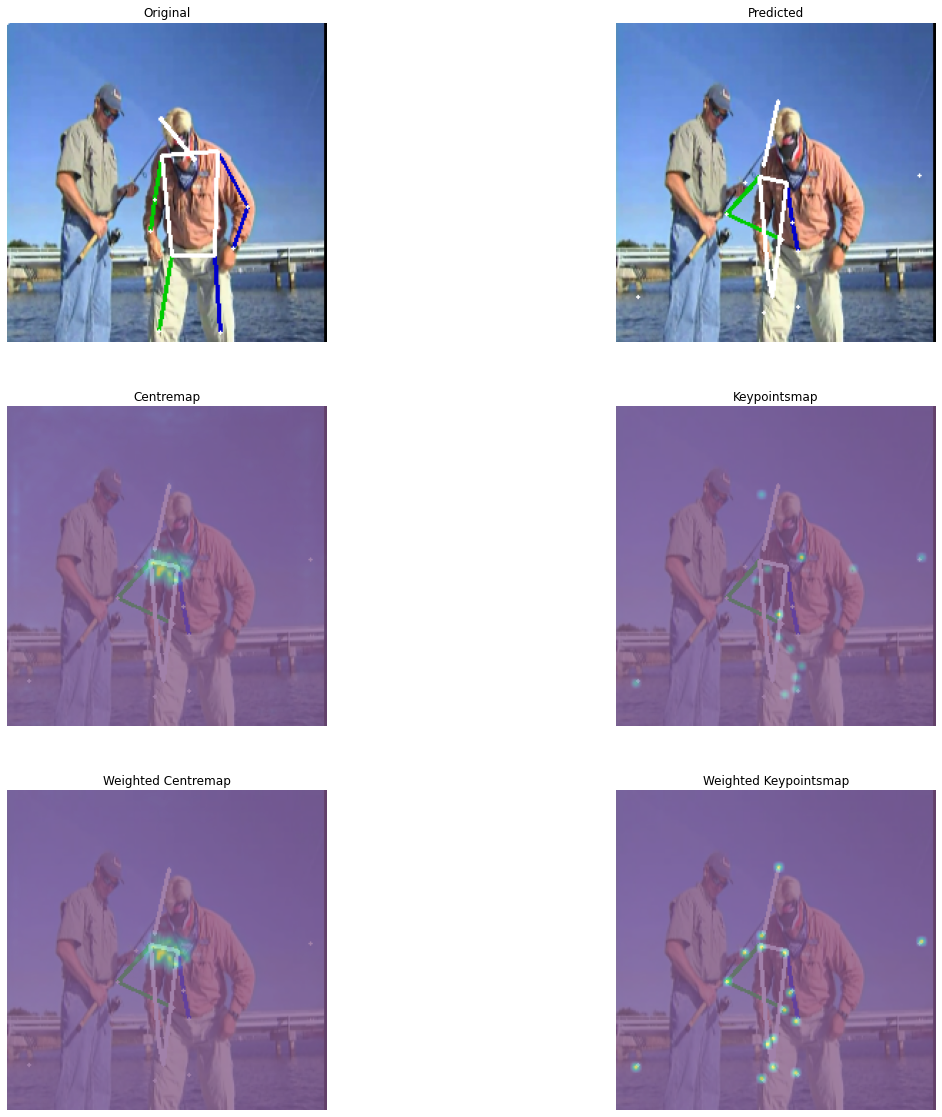

In [12]:
draw_sample(1)

In [9]:

def draw_centermap(i):
    pred_img = ((img[i].numpy() + 1) * 127.5).astype('uint8').copy()
    true_img = ((img[i].numpy() + 1) * 127.5).astype('uint8').copy()
    
    preds, heatmaps, w_heatmaps = model.predict(img[i:i+1])
    preds = preds[0, :, :3]
    preds = preds[:, [1,2,0]]
    
    # Heatmaps
    centremap = heatmaps[0, :, 0].reshape(GRID_SIZE, GRID_SIZE)
    centremap = cv2.resize(centremap, INPUT_SHAPE[:2])
    
    # Weighted heatmaps
    w_centremap = w_heatmaps[0, :, 0].reshape(GRID_SIZE, GRID_SIZE)
    w_centremap = cv2.resize(w_centremap, INPUT_SHAPE[:2])
    
    
    labels = y2[i, :, 0].numpy().reshape(GRID_SIZE, GRID_SIZE)
    
    fig, axs = plt.subplots(2, 2)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    
    axs[0,0].imshow(true_img, alpha=.2)
    axs[0,0].imshow(labels, alpha=.8)
    axs[0,0].axis('off')
    axs[0,0].set_title("Original")
    
    axs[0,1].imshow(pred_img, alpha=.2)
    axs[0,1].imshow(centremap, alpha=.8)
    axs[0,1].axis('off')
    axs[0,1].set_title("Predicted")
    
    axs[1,0].imshow(true_img, alpha=.2)
    axs[1,0].imshow(labels,  alpha=.8)
    axs[1,0].axis('off')
    axs[1,0].set_title("Weighted Centremap")
    
    axs[1,1].imshow(pred_img, alpha=.5)
    axs[1,1].imshow(w_centremap,  alpha=.5)
    axs[1,1].axis('off')
    axs[1,1].set_title("Keypointsmap")

1/1 [==============================] - 0s 54ms/step


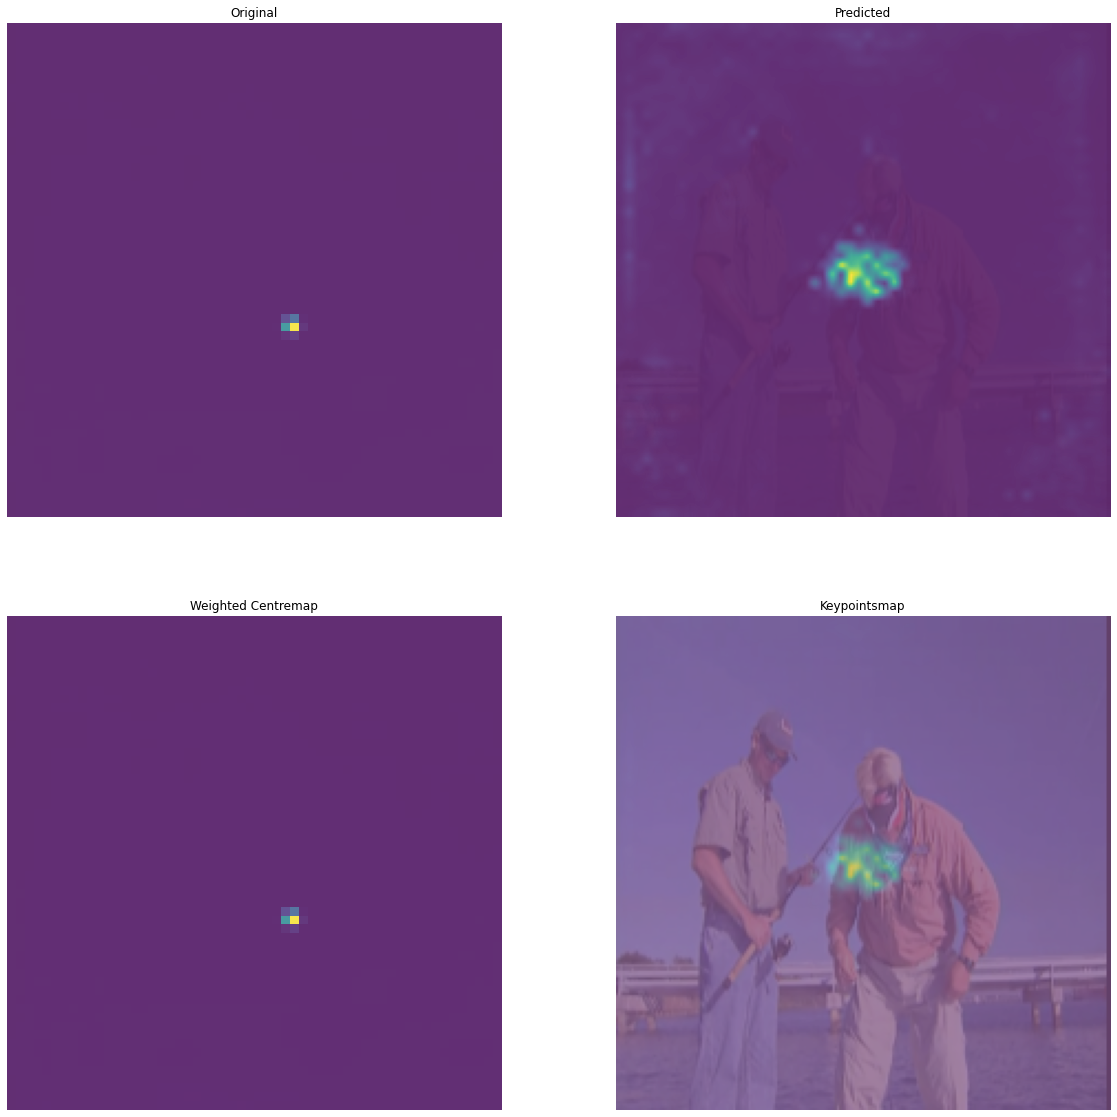

In [13]:
draw_centermap(1)

In [14]:

def draw_kpts_heatmap(i, j):
    pred_img = ((img[i].numpy() + 1) * 127.5).astype('uint8').copy()
    true_img = ((img[i].numpy() + 1) * 127.5).astype('uint8').copy()
    
    preds, heatmaps, w_heatmaps = model.predict(img[i:i+1])
    preds = preds[0, :, :3]
    preds = preds[:, [1,2,0]]
    
    # Heatmaps
    kptsmap = heatmaps[0, :, j].reshape(GRID_SIZE, GRID_SIZE)
    kptsmap = cv2.resize(kptsmap, INPUT_SHAPE[:2])
    
    # Weighted heatmaps
    w_kptsmap = w_heatmaps[0, :, j].reshape(GRID_SIZE, GRID_SIZE)
    w_kptsmap = cv2.resize(w_kptsmap, INPUT_SHAPE[:2])
    
    
    labels = y2[i, :, 0].numpy().reshape(GRID_SIZE, GRID_SIZE)
    
    fig, axs = plt.subplots(2, 2)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    
    axs[0,0].imshow(true_img, alpha=.2)
    axs[0,0].imshow(labels, alpha=.8)
    axs[0,0].axis('off')
    axs[0,0].set_title("Original")
    
    axs[0,1].imshow(pred_img, alpha=.2)
    axs[0,1].imshow(kptsmap, alpha=.8)
    axs[0,1].axis('off')
    axs[0,1].set_title("Predicted")
    
    axs[1,0].imshow(true_img, alpha=.2)
    axs[1,0].imshow(labels,  alpha=.8)
    axs[1,0].axis('off')
    axs[1,0].set_title("Weighted Centremap")
    
    axs[1,1].imshow(pred_img, alpha=.5)
    axs[1,1].imshow(w_kptsmap,  alpha=.5)
    axs[1,1].axis('off')
    axs[1,1].set_title("Keypointsmap")

1/1 [==============================] - 0s 63ms/step


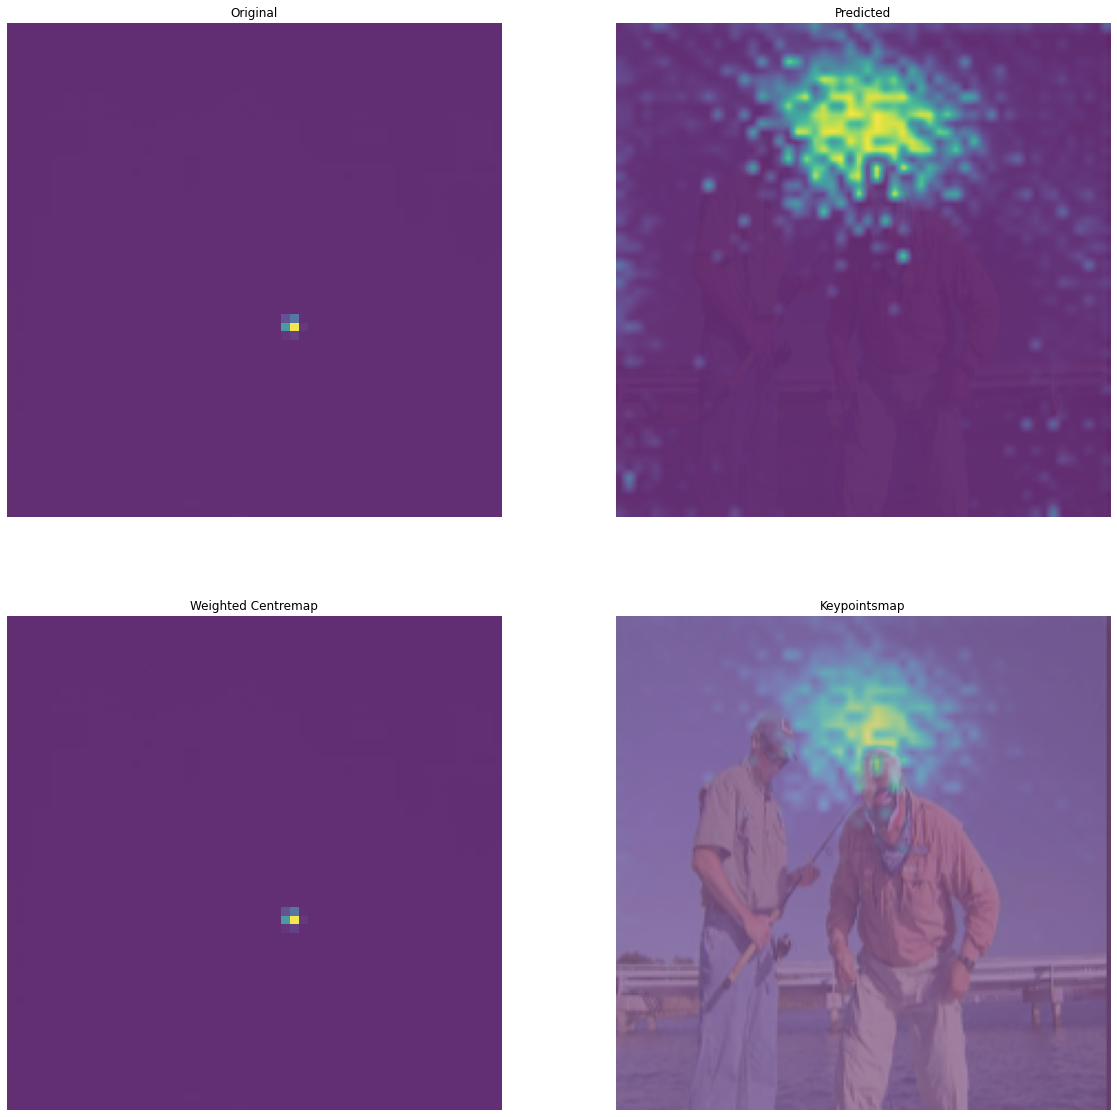

In [25]:
draw_kpts_heatmap(1, 10)